# CEB 35300, Phylogenetic Comparative Methods 
## University of Chicago, 2018<br>Andrew Hipp, ahipp@mortonarb.org
### Session 8: Measurement error

It's rarely the case that the data we gather represents measurements known without error. Generally there is variance on those estimates, a consequence of measurement error and biological variation. In two of the papers you read for this week (Silvestro et al. 2015; Harmon and Losos 2005) use simulation to demonstrate that:

1. __Ignoring intraspecific variance biases phylogenetic signal estimates downward__, which can be particularly pernicious when we are interpreting the O-U $\alpha$ parameter as an estimate of rate of adaptation.
1. __Ignoring intraspecific variance biases regression slopes / correlations downward__
1. __The problems with intraspecific variance can be corrected by:__
    1. modeling sampling error (see Ives et al. 2007, Felsenstein 2008, Hansen and Bartoszek 2012),
    1. increasing within-species sampling, or 
    1. increasing among-species variation relative to within-species variation (hard to do unless you are extra choosey about your groups... 
    1. but _not_ by increasing the number of species you sample. Somewhat counter-intuitively, this only makes things worse.
    
Let's look at some of these problems ourselves.

# Simulating data with and without sampling error
Let's start with an easy simulation: we'll simulate a tree with 100 tips, then a bivariate character with variance of 1 and covariance of 0.6, then simulate a sampling process. First the tree:

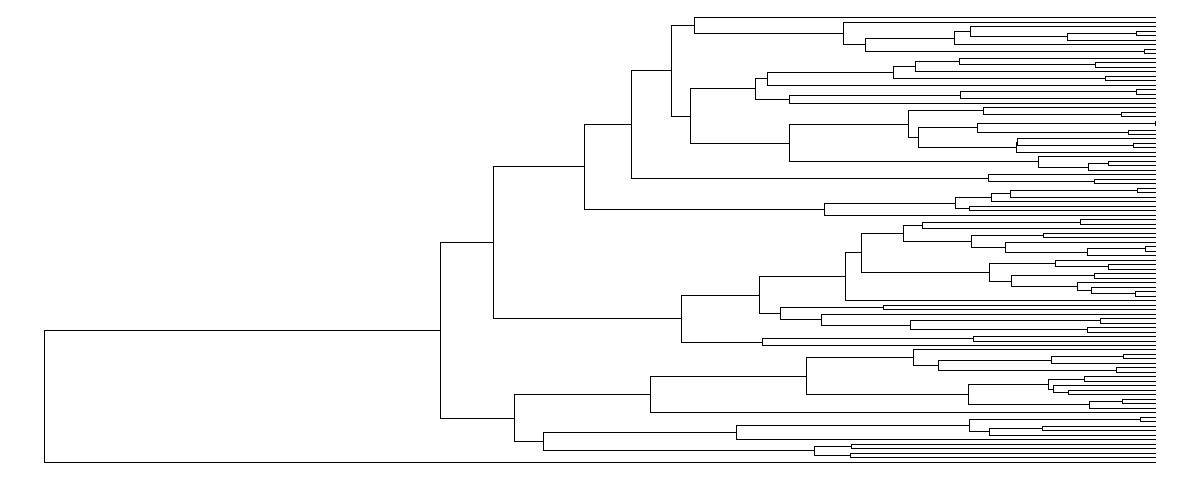

In [174]:
library(geiger)
tr <- sim.bdtree(n = 100)
options(repr.plot.width=10, repr.plot.height=4)
par(mar = c(0,0,0,0))
plot(tr, show.tip.label = F)

Now, let's simulate a bivariate dataset:

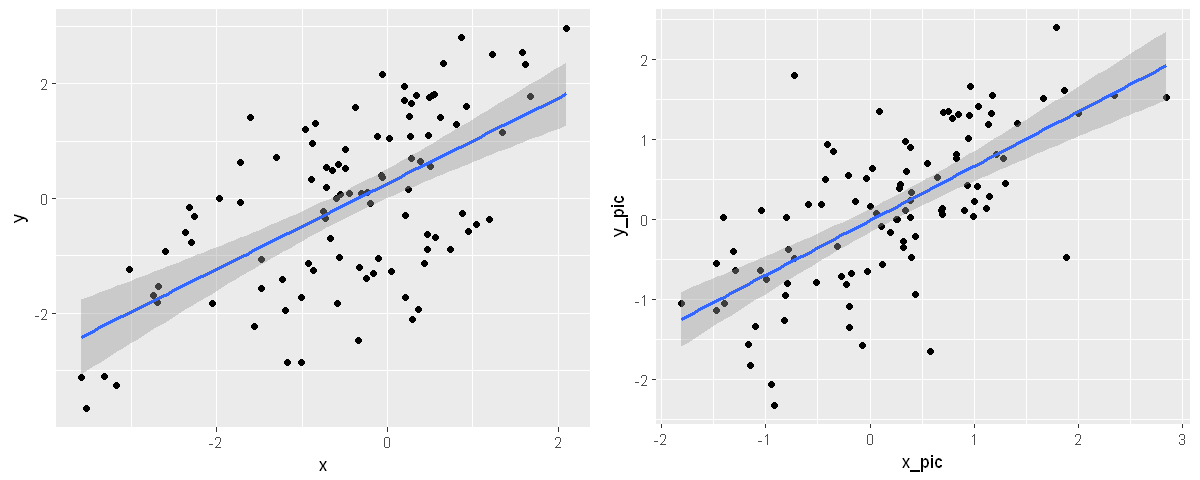

In [175]:
library(ggplot2)
library(gridExtra)

dat <- sim.char(tr, matrix(c(1,0.6,0.6,1), 2, 2), nsim = 500)
a = as.data.frame(dat[,,1])
names(a) <- c('x','y')

p1 <- ggplot(a, aes(x=x, y=y)) + geom_point() + geom_smooth(method = 'lm')

a.pic <- data.frame(x_pic = pic(a$x, tr),
                     y_pic = pic(a$y, tr))
p2 <- ggplot(a.pic, aes(x=x_pic, y=y_pic)) + geom_point() + geom_smooth(method = 'lm')
grid.arrange(grobs = list(p1, p2), ncol = 2, main = "Raw data and independent contrasts")

... and let's convince ourselves that we can recover the correlation when the data are known without error:

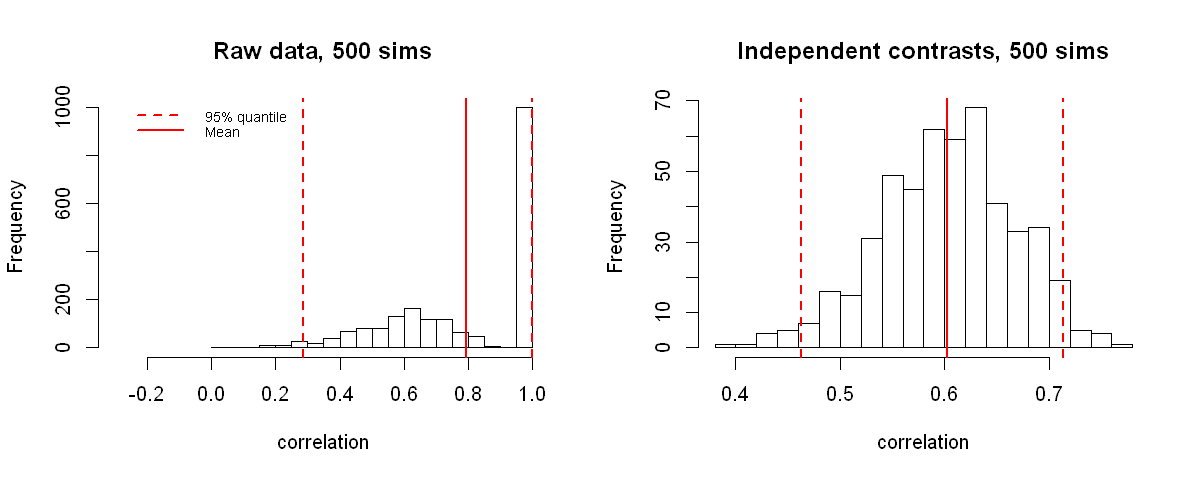

In [176]:
dat.cor <- apply(dat, 3, cor)
dat.pic.cor <- apply(dat, 3, function(x) cor(pic(x[, 1], tr), pic(x[, 2], tr)))
layout(matrix(1:2, 1))
hist(dat.cor, 20, xlab = 'correlation', main = 'Raw data, 500 sims',
     xlim = c(-0.3, 1))
abline(v = c(quantile(dat.cor, c(0.025, 0.975)), mean(dat.cor)), 
       lty = c('dashed', 'dashed', 'solid'), lwd = 2, col = 'red')
legend(-0.3, 1000, c('95% quantile', '', 'Mean'), 
       lty = c('dashed', NA, 'solid'), lwd = 2, col = 'red', 
       bty = 'n', cex = 0.7)
hist(dat.pic.cor, 20, xlab = 'correlation', main = 'Independent contrasts, 500 sims')
abline(v = c(quantile(dat.pic.cor, c(0.025, 0.975)), mean(dat.pic.cor)), 
       lty = c('dashed', 'dashed', 'solid'), lwd = 2, col = 'red')

# Effects of measurement error on correlation estimates
Now that we have our data and we've convinced ourselves that we can get the right correlation ($r = 0.6$) using independent contrasts if we know the data without error, let's look at how sampling error affects our understanding. We'll simulate the sampling process by assuming that in each species, the within-species standard deviation is 0.58, corresponding to approximately $1 \over 3$ the variance under which we simulated our data ($\sigma^2 = 1$). For each simulated dataset, we'll sample 5, 10, 20, and 50 individuals and take the mean:

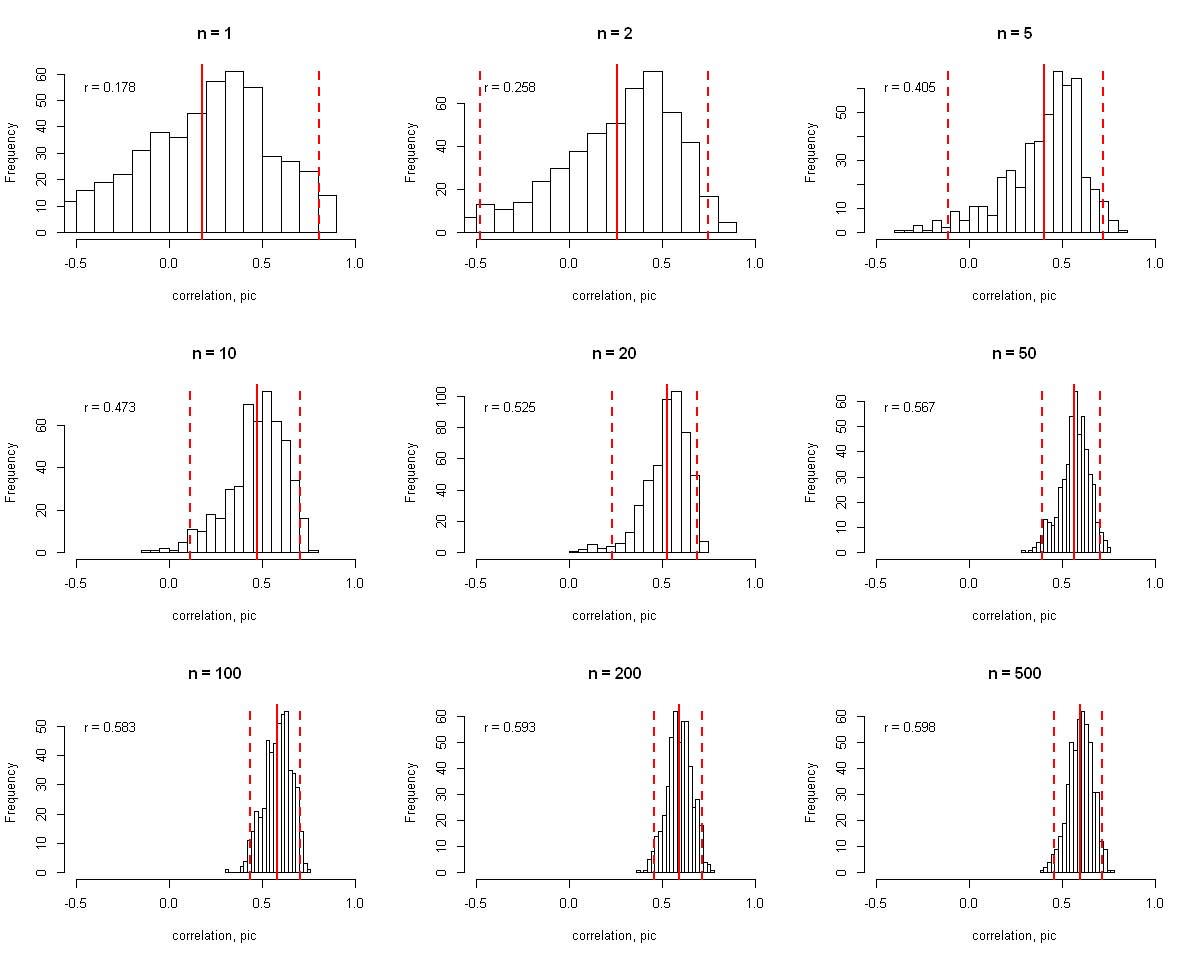

In [177]:
sigma = 0.58
n = c(1, 2, 5, 10, 20, 50, 100, 200, 500)
dat.sampled <- lapply(n, function(nSamples) {
    apply(dat, 1:3, function(x) mean(rnorm(mean = x, sd = sigma, n = nSamples)))
        })
names(dat.sampled) <- paste('n =', n)

layout(matrix(c(1:9), 3, 3, byrow = T))
options(repr.plot.width=10, repr.plot.height=8)

for(i in names(dat.sampled)) {
    dat.sampled.pic <- apply(dat.sampled[[i]], 3, function(x) cor(pic(x[, 1], tr), pic(x[, 2], tr)))
    a=hist(dat.sampled.pic, 20, xlab = 'correlation, pic', xlim = c(-0.5, 1), main = i)
    abline(v = c(quantile(dat.sampled.pic, c(0.025, 0.975)), mean(dat.sampled.pic)),
           lty = c('dashed', 'dashed', 'solid'), lwd = 2, col = 'red')
    text(-0.5, 0.9*max(a$counts), paste('r =', round(mean(dat.sampled.pic), 3)), pos = 4)
}

You can see here two effects of sampling error: failing to account for it depresses your estimates of correlation between two traits, and this is evident at any sampling level... but much worse when we don't sample many individuals. Think how you would be thrown off if you had a sample of only two or three individuals per species... and that's quite common! 

# Effect of measurement error on univariate models of evolution
As if this weren't bad enough, measurement error wrecks havoc on single-trait macroevolutionary scenarios as well. Let's look at a case in which we are trying to quantify phylogenetic signal using a single-optimum O-U model. We know that all the traits we have evolved on the tree have a good phylogenetic signal. Let's calculate lambda for a few datasets known without error, and a few from our 5-individuals-per-species and 1-individual per species datasets:

In [178]:
options(warn=-1)
dat.noME.lambda <- apply(dat[,,1:20], 3, function(x) fitContinuous(tr, x[,1], model = 'OU'))
a=round(sapply(dat.noME.lambda, function(x) x$opt$alpha), 3)
print(paste('Data known without error; OU alpha:', round(mean(a), 3), '+/-', round(sd(a), 3)))
    
dat.ME5.lambda <- apply(dat.sampled$'n = 5'[,,1:20], 3, function(x) fitContinuous(tr, x[,1], model = 'OU'))
a=round(sapply(dat.ME5.lambda, function(x) x$opt$alpha), 3)
print(paste('Data based on 5 individuals per species; OU alpha:', round(mean(a), 3), '+/-', round(sd(a), 3)))
    
dat.ME1.lambda <- apply(dat.sampled$'n = 2'[,,1:20], 3, function(x) fitContinuous(tr, x[,1], model = 'OU'))
a=round(sapply(dat.ME1.lambda, function(x) x$opt$alpha), 3)
print(paste('Data based on 2 individuals per species; OU alpha:', round(mean(a), 3), '+/-', round(sd(a), 3)))

[1] "Data known without error; OU alpha: 0.135 +/- 0.144"
[1] "Data based on 5 individuals per species; OU alpha: 0.727 +/- 0.653"
[1] "Data based on 2 individuals per species; OU alpha: 1.279 +/- 0.782"


This illustrates the very first point at the top of the page. However, there is a work-around. Both Felsenstein 2008 and Ives et al. 2007 make the point that sampling error has the effect of increasing variance in any trait we are looking at, without affecting covariance: this is equivalent to adding tip length to the tree or adding the measurement error to the diagonal of the covariance matrix... at least roughly. In GLS, what one actually does is add the squared standard error of the mean to the diagonal of the rescaled covariance matrix ($V = \sigma^2 C$). Why the squared standard error? Because standard error is calculated as $\sigma \over \sqrt{N}$, but the covariance matrix is scaled by $\sigma^2$, not $\sigma$. 

There is a complication here. You can't just trot in and calculate the standard errors for all your species, square them, and add them to the covariance matrix, because $\sigma^2$ is calculated using GLS _based on your data and $C$_. As a consequence, you have to iteratively estimate $\sigma^2$ and $\hat{a}$, adding $\sigma^2 \over N$ to the diagonal of $C$ at each round, until you converge on parameter estimates that don't change much from one iteration to the next. 

Rather than do this by hand, let's let `geiger` do the work. Ordinarily, one calculates or estimates the standard error for each species and passes this in as a vector (though see discussions in Ives et al. 2007, Felsenstein 2008, Hansen and Bartoszek 2012 regarding what to do if you don't have an estimate of your measurement error), but we happen to know precisely what our measurement error is, because we simulated our data. _Note that geiger asks for the standard error, not the squared standard error._ Let's try it out:

In [179]:
options(warn=-1)

a=round(sapply(dat.noME.lambda, function(x) x$opt$alpha), 3)
print(paste('Data known without error; OU alpha:', round(mean(a), 3), '+/-', round(sd(a), 3)))
    
dat.ME5.lambda <- apply(dat.sampled$'n = 5'[,,1:20], 3, function(x) fitContinuous(tr, x[,1], model = 'OU', SE = sigma / sqrt(5)))
a=round(sapply(dat.ME5.lambda, function(x) x$opt$alpha), 3)
print(paste('Data based on 5 individuals per species with measurement error; OU alpha:', round(mean(a), 3), '+/-', round(sd(a), 3)))
    
dat.ME1.lambda <- apply(dat.sampled$'n = 2'[,,1:20], 3, function(x) fitContinuous(tr, x[,1], model = 'OU', SE = sigma / sqrt(2)))
a=round(sapply(dat.ME1.lambda, function(x) x$opt$alpha), 3)
print(paste('Data based on 2 individuals per species with measurement error; OU alpha:', round(mean(a), 3), '+/-', round(sd(a), 3)))

[1] "Data known without error; OU alpha: 0.135 +/- 0.144"
[1] "Data based on 5 individuals per species with measurement error; OU alpha: 0.179 +/- 0.165"
[1] "Data based on 2 individuals per species with measurement error; OU alpha: 0.157 +/- 0.167"


Now our estimates of the O-U $\alpha$ parameter are quite comparable across datasets... not identical, and variance on the estimate increases with decreasing within-species sampling, but we would expect it to.

As you analyze your own data and assess methods for data analysis, consider whether the implementation you are utilizing incorporates within-species measurement error, and how you want to model measurement error and within-species variation. Not doing so will likely have implications for your conclusions.

# Packages and implementations that incorporate measurement error
I have not tried to find every implementation that incorporates measurement error, but I can point you to at least a few:
* __`geiger`__ -- within `geiger`, the `auteur` rjMCMC approach and `fitContinuous` both incorporate ME; use measurement error
* __`mvSLOUCH`__ -- incorporates the Hansen and Bartoszek approaches to intraspecific variance
* __`phytools`__ -- the `pgls.Ives` and `pgls.SEy` functions implement the Ives et al. approach to modelling intraspecific variance

# Problems for you to work on alone or with a labmate
1. Simulate a tree and apply a rate transformation in which there is an increase in rate of evolution over time (hint: look back at the tutorial for week 5, "Stretching the tree"). Evolve traits on the transformed tree as well as the untransformed tree, and then simulate a sampling process as we just did above. How does sampling error affect your ability to detect an early-burst model? Suppose you test a rate-change model vs a no-rate-change model on the untransformed tree: how does measurement error affect your inferences about how evolution has proceeded? Does this change if you model the measurement error appropriately in the `fitContinuous` function instead of treating the data as known without error?

1. In our simulation above, we have looked at the effects of within-species sampling on parameter estimates, not the effects of species number. Simulate a gradient of trees (perhaps sizes 20, 50, 100, 200, 500) to see how tree size affects parameter estimation (e.g., Pagel's $\lambda$ or $\delta$, the O-U $\alpha$, the EB or ACDC parameter). Remember to simulate the sampling process for the data, so that you are taking into account the effect of measurement error as a function of among-species sample size.

1. A close inspection of Hipp et al. 2018, the source for the datasets you downloaded and formatted in week 1 of this course, might suggest that the authors did _not_ incorporate measurement error in their analyses. Funny. Try to replicate some of the regressions in this paper or a favorite of your own, adding measurement error in where previously it was not. Do the results change? how? Try to make your trial a regression, utilizing either the `mvSLOUCH` approach or the Ives et al. approach as implemented in `phytools`.